# Implementando uma Deep Learning do zero em Python

**MNIST:** reconhecer números escritos a mão

## 1 - Importando bibliotecas

In [14]:
# conda install -c pytorch pytorch
# conda install -c pytorch torchvision


In [15]:
import matplotlib.pyplot as plt
import numpy as np
from time import time
# pytorch 
import torch
import torch.nn.functional as F
import torchvision 
from torchvision import datasets, transforms
from torch import nn, optim


## 2 - Dataset

In [16]:
# definindo a conversão de imagem para tensor
transform = transforms.ToTensor()

# carrega a parte de treino do dataset - download e salva na pasta MNIST_data
trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)

# cria um buffer para pegar os dados por partes
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# carrega a parte de validação do dataset
valset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)

# cria um buffer para pegar os dados por partes
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

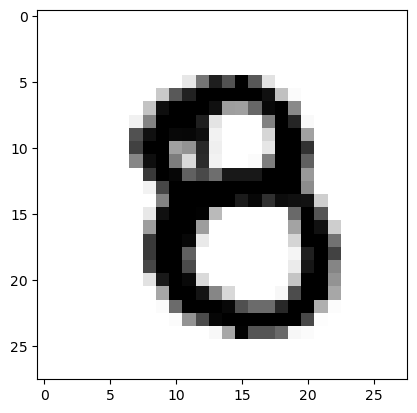

In [17]:
# representação de um digito so para ver o dado
dataiter = iter(trainloader)
imagens, etiqueta = next(dataiter)

plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')

In [18]:
# conferir o tamanho do tensor que representa uma imagem
# verificar as dimensões do tensor de cada imagem
print(imagens[0].shape)
# verificar as dimensões do tensor de cada etiqueta
print(etiqueta[0].shape)

torch.Size([1, 28, 28])
torch.Size([])


## 3 - Iniciando a Rede

keras inception v3

<https://keras.io/api/applications/>

In [19]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        # camada de entrada, 784 neuronios que se ligam a 128
        self.linear1 = nn.Linear(28*28, 128)
        # camada interna 1, 128 neuronios que se ligam a 64
        self.linear2 = nn.Linear(128, 64)
        # camada interna 2, 64 neuronios que se ligam a 10
        self.linear3 = nn.Linear(64,10)
        # para camada de saida não é necessário definir nda pois só precisamos pegar o output da camada interna 2

        def forward(self, X):
            # função de ativação da camada de entrada para a camada interna 1
            X = F.relu(self.linear1(X))
            # função de ativação da camada de interna 1 para a camada interna 2
            X = F.relu(self.linear2(X))
            # função de ativação da camada de interna 2 para a camada de saída, necesse caso f(x) = x
            X = F.relu(self.linear3(X))
            # dados utilizados para calcular a perda
            return F.log_softmax(X, dim=1)

Otimização da Rede

In [20]:
def treino(modelo, trainloader, device):
  # define a politica de atualização dos pesos e da bias
  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) 
  # timer para saber quanto tempo levou o treino
  inicio = time() 
  # definindo o criterio para calcular a perda
  criterio = nn.NLLLoss() 
  # numero de epochs que o algoritmo rodará - tempo de treinamento - epoca 
  # um bom treinamento é no minimo de 100
  EPOCHS = 100 
  # ativando o modo de treinamento do modelo
  modelo.train()

   
  for epoch in range(EPOCHS):
    # inicialização da perda acumulada da epoch em questão
    perda_acumulada =0 
    for imagens, etiquetas in trainloader:
      # convertendo as imagens para vetores de 28*28 casas
      imagens = imagens.view(imagens.shape[0], -1) 
      # zerando os gradientes por conta do ciclo anterior
      otimizador.zero_grad() 
      # colocando os dados no modelo
      output = modelo(imagens.to(device)) 
      # calculando a perda da epoch em questão
      perda_instantanea = criterio(output, etiquetas.to(device)) 
      # back propagation a partir da perda
      perda_instantanea.backward() 
      # atualizando os pesos e a bias
      otimizador.step() 
      # atualização da perda acumulada
      perda_acumulada += perda_instantanea.item() 
    else:
      print("Epoch {} - perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
  print("\nTempo de treino (em minutos) = ",(time()-inicio)/60)

Verificar a acuracia

Comparar a imagem que não foi treinada com a rede e seus pesos de treinamento. 

In [21]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagens,etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784)
      #desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um custo alto de processamento
      with torch.no_grad():
        logps = modelo(img.to(device)) # output do modelo em escala logaritmica
      # converte output para escala normal( lembrando que é um tensor)
      ps = torch.exp(logps) 
      probab = list(ps.cpu().numpy()[0])
      # converte o tensor em um número, no caso, o numero que o modelo previu
      etiqueta_pred = probab.index(max(probab)) 
      etiqueta_certa = etiquetas.numpy()[i]
      #compara a previsão com o valor correto
      if(etiqueta_certa == etiqueta_pred):  
        conta_corretas += 1
      conta_todas += 1
  
  print("Total de imagens testadas =", conta_todas)
  print("\nPrecisão do modelo = {} %".format((conta_corretas*100)/conta_todas))

In [22]:
modelo = Modelo()
# verificar se tem o cuda disponivel, se não vai ser pela cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

Chamar o treino do modelo.